In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
from GPErks.gp.experiment import GPExperiment
from GPErks.train.emulator import GPEmulator
from GPErks.perks.inference import Inference
from GPErks.train.early_stop import NoEarlyStoppingCriterion
from GPErks.train.early_stop import (
    GLEarlyStoppingCriterion,
    PQEarlyStoppingCriterion,
    UPEarlyStoppingCriterion,
)
from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 7
set_seed(seed)

# Model 1: Basic GP

In [2]:
x_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\input\xlabels_EP.txt',delim_whitespace=True,header=None)
inputOrig = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\input\X_EP.txt',index_col=None,delim_whitespace=True,header=None)
inputOrig.columns=x_labels
print(inputOrig)

     (CV_ventricles,)  (k_ventricles,)  (k_FEC,)  (CV_atria,)  (k_atria,)  \
0            0.399840         0.323390   2.38256     0.792266    0.418700   
1            0.411078         0.484808   2.97470     0.436497    0.392057   
2            0.480070         0.255120   5.45824     0.707493    0.233964   
3            0.723138         0.219679   7.08363     1.011880    0.440564   
4            0.613551         0.212641   6.01868     0.914252    0.278204   
..                ...              ...       ...          ...         ...   
175          0.787312         0.392919   4.22219     0.385685    0.226360   
176          0.436460         0.348932   3.06019     0.699568    0.471580   
177          0.484816         0.466268   1.34156     0.437907    0.377097   
178          0.734602         0.210847   1.62463     0.444901    0.404824   
179          0.692167         0.415612   3.02559     0.847270    0.442109   

     (k_BB,)  
0    5.13714  
1    2.72577  
2    5.18898  
3    2.02218  


In [3]:
y_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\output\ylabels.txt',delim_whitespace=True,header=None)
outputOrig = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\output\Y.txt',index_col=None,delim_whitespace=True,header=None)
outputOrig.columns=y_labels
print(outputOrig)

     (A_TAT,)  (V_TAT,)
0     127.156  227.8230
1     251.071  188.8540
2     163.448  164.8120
3     110.207  110.6940
4     140.815  136.1450
..        ...       ...
175   321.082   94.4139
176   141.936  190.0140
177   236.662  224.8330
178   248.667  167.9450
179   118.693  115.3070

[180 rows x 2 columns]


In [4]:
# split original dataset in training, validation and testing sets
X=inputOrig
y=outputOrig
X_, X_test, y_, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_,
    y_,
    test_size=0.2,
    random_state=seed
)

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 6
-Input parameters: ['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']
-Output size: 1
-Output feature: [array(['A_TAT'], dtype=object)]
-Sample size: 144
-Discrepancy: 0.0086
-Validation data available: No
-Testing data available: Yes (size = 36)


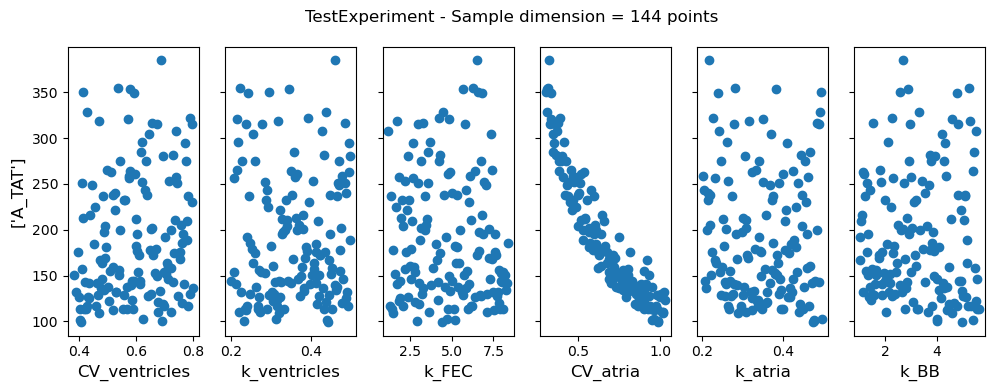

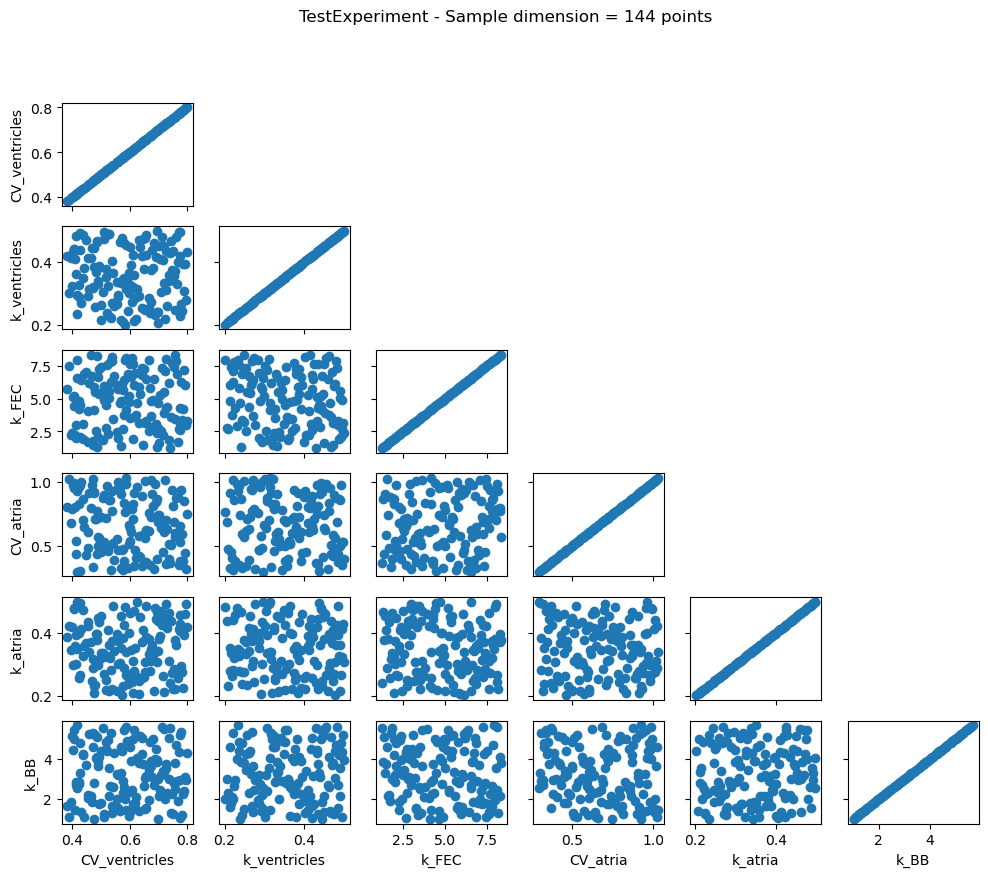

In [5]:

dataset = Dataset(
        X_.values,
        y_.iloc[:,0].values,
        X_test=X_test.values,
        y_test=y_test.iloc[:,0].values,
        x_labels=x_labels.values.squeeze().tolist(),
        y_label=y_labels.values[0],
    
        )
dataset.plot()
dataset.plot_pairwise()

In [6]:
np.min(y_train)

C:\Users\pmzcwl\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


(A_TAT,)    98.9795
(V_TAT,)    82.2549
dtype: float64

In [7]:
from GPErks.gp.data.dataset import Dataset

In [8]:
x_labels.values.squeeze().tolist()

['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']

In [9]:
best_models=[]
best_train_stats=[]
emulators=[]
nMod = y_train.shape[1]
mse=[]
    
for i in range(nMod):

    
    dataset = Dataset(
        X_train.values,
        y_train.iloc[:,i].values,
        X_val=X_val.values,
        y_val=y_val.iloc[:,i].values,
        X_test=X_test.values,
        y_test=y_test.iloc[:,i].values,
        x_labels=x_labels.values.squeeze().tolist(),
        y_label=y_labels.values[i],
    
        )

    likelihood = GaussianLikelihood()
    mean_function = LinearMean(input_size=dataset.input_size)
    kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))
    metrics = [MeanSquaredError(), R2Score()]

    experiment = GPExperiment(
        dataset,
        likelihood,
        mean_function,
        kernel,
        n_restarts=5,
        metrics=metrics,
        seed=seed,  # reproducible training
        learn_noise=True
    )

    device = "cpu"
    optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)

    emulator = GPEmulator(experiment, device)
    best_model, best_train_stat = emulator.train(optimizer);
    mean,std=emulator.predict(X_test.values)
    mse.append(((mean-y_test.iloc[:,i].values)**2).mean())
    emulators.append(emulator)
    best_models.append(best_model)
    best_train_stats.append(best_train_stat)

INFO:2023-07-17 10:47:10,236:emulator:train:L84: Training emulator...
INFO:2023-07-17 10:47:10,238:emulator:train:L100: Running restart 1...


TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 6
-Input parameters: ['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']
-Output size: 1
-Output feature: [array(['A_TAT'], dtype=object)]
-Sample size: 115
-Discrepancy: 0.0159
-Validation data available: Yes (size = 29)
-Testing data available: Yes (size = 36)


C:\Users\pmzcwl\AppData\Local\anaconda3\lib\site-packages\gpytorch\models\exact_gp.py:283: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2023-07-17 10:47:10,674:emulator:_train_once:L316: [  1/100] Training Loss: 1.3130 - MeanSquaredError: 0.3438 - R2Score: 0.6562 | Validation Loss: 1.2321 - MeanSquaredError: 0.6122 - R2Score: 0.5976
INFO:2023-07-17 10:47:10,692:emulator:_train_once:L316: [  2/100] Training Loss: 1.2454 - MeanSquaredError: 0.2691 - R2Score: 0.7309 | Validation Loss: 1.1720 - MeanSquaredError: 0.5157 - R2Score: 0.6610
INFO:2023-07-17 10:47:10,711:emulator:_train_once:L316: [  3/100] Training Loss: 1.1883 - MeanSquaredError: 0.2094 - R2Score: 0.7906 | Validation Loss: 1.1120 - MeanSquaredError: 0.4288 - R2Score: 0.7181
INFO:2023-07-17 10:47:10,729:emulator:_train_once:L316: [  4/100] Training Loss: 1.1333 - MeanSquaredError: 0.1635 - R2Score: 0.8365 | Validation Loss: 1.0545 - MeanSquaredError: 0.3

INFO:2023-07-17 10:47:11,557:emulator:_train_once:L316: [ 41/100] Training Loss: -0.4212 - MeanSquaredError: 0.0085 - R2Score: 0.9915 | Validation Loss: -0.6794 - MeanSquaredError: 0.0113 - R2Score: 0.9926
INFO:2023-07-17 10:47:11,578:emulator:_train_once:L316: [ 42/100] Training Loss: -0.4504 - MeanSquaredError: 0.0078 - R2Score: 0.9922 | Validation Loss: -0.7158 - MeanSquaredError: 0.0110 - R2Score: 0.9928
INFO:2023-07-17 10:47:11,597:emulator:_train_once:L316: [ 43/100] Training Loss: -0.4801 - MeanSquaredError: 0.0070 - R2Score: 0.9930 | Validation Loss: -0.7539 - MeanSquaredError: 0.0107 - R2Score: 0.9930
INFO:2023-07-17 10:47:11,616:emulator:_train_once:L316: [ 44/100] Training Loss: -0.5114 - MeanSquaredError: 0.0061 - R2Score: 0.9939 | Validation Loss: -0.7974 - MeanSquaredError: 0.0100 - R2Score: 0.9934
INFO:2023-07-17 10:47:11,638:emulator:_train_once:L316: [ 45/100] Training Loss: -0.5475 - MeanSquaredError: 0.0051 - R2Score: 0.9949 | Validation Loss: -0.8475 - MeanSquaredEr

INFO:2023-07-17 10:47:12,390:emulator:_train_once:L316: [ 81/100] Training Loss: -1.4689 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.0592 - MeanSquaredError: 0.0008 - R2Score: 0.9995
INFO:2023-07-17 10:47:12,409:emulator:_train_once:L316: [ 82/100] Training Loss: -1.4820 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.0806 - MeanSquaredError: 0.0008 - R2Score: 0.9995
INFO:2023-07-17 10:47:12,429:emulator:_train_once:L316: [ 83/100] Training Loss: -1.4936 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.1022 - MeanSquaredError: 0.0008 - R2Score: 0.9995
INFO:2023-07-17 10:47:12,449:emulator:_train_once:L316: [ 84/100] Training Loss: -1.5040 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.1255 - MeanSquaredError: 0.0007 - R2Score: 0.9995
INFO:2023-07-17 10:47:12,470:emulator:_train_once:L316: [ 85/100] Training Loss: -1.5145 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.1427 - MeanSquaredEr

INFO:2023-07-17 10:47:13,237:emulator:_train_once:L316: [ 21/100] Training Loss: 0.0017 - MeanSquaredError: 0.0110 - R2Score: 0.9890 | Validation Loss: -0.1455 - MeanSquaredError: 0.0344 - R2Score: 0.9774
INFO:2023-07-17 10:47:13,258:emulator:_train_once:L316: [ 22/100] Training Loss: -0.0475 - MeanSquaredError: 0.0108 - R2Score: 0.9892 | Validation Loss: -0.1963 - MeanSquaredError: 0.0326 - R2Score: 0.9785
INFO:2023-07-17 10:47:13,277:emulator:_train_once:L316: [ 23/100] Training Loss: -0.0939 - MeanSquaredError: 0.0105 - R2Score: 0.9895 | Validation Loss: -0.2483 - MeanSquaredError: 0.0306 - R2Score: 0.9799
INFO:2023-07-17 10:47:13,298:emulator:_train_once:L316: [ 24/100] Training Loss: -0.1377 - MeanSquaredError: 0.0101 - R2Score: 0.9899 | Validation Loss: -0.3021 - MeanSquaredError: 0.0283 - R2Score: 0.9814
INFO:2023-07-17 10:47:13,324:emulator:_train_once:L316: [ 25/100] Training Loss: -0.1801 - MeanSquaredError: 0.0095 - R2Score: 0.9905 | Validation Loss: -0.3581 - MeanSquaredErr

INFO:2023-07-17 10:47:14,126:emulator:_train_once:L316: [ 61/100] Training Loss: -1.3812 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.9407 - MeanSquaredError: 0.0011 - R2Score: 0.9993
INFO:2023-07-17 10:47:14,145:emulator:_train_once:L316: [ 62/100] Training Loss: -1.3981 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -1.9614 - MeanSquaredError: 0.0011 - R2Score: 0.9993
INFO:2023-07-17 10:47:14,165:emulator:_train_once:L316: [ 63/100] Training Loss: -1.4136 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -1.9817 - MeanSquaredError: 0.0010 - R2Score: 0.9993
INFO:2023-07-17 10:47:14,185:emulator:_train_once:L316: [ 64/100] Training Loss: -1.4275 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.0038 - MeanSquaredError: 0.0010 - R2Score: 0.9994
INFO:2023-07-17 10:47:14,210:emulator:_train_once:L316: [ 65/100] Training Loss: -1.4416 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.0294 - MeanSquaredEr

INFO:2023-07-17 10:47:14,997:emulator:train:L113: Run restart 2.
INFO:2023-07-17 10:47:14,998:emulator:train:L100: Running restart 3...
INFO:2023-07-17 10:47:15,027:emulator:_train_once:L316: [  1/100] Training Loss: 1.4325 - MeanSquaredError: 0.2014 - R2Score: 0.7986 | Validation Loss: 1.3711 - MeanSquaredError: 0.6739 - R2Score: 0.5570
INFO:2023-07-17 10:47:15,050:emulator:_train_once:L316: [  2/100] Training Loss: 1.4131 - MeanSquaredError: 0.1924 - R2Score: 0.8076 | Validation Loss: 1.3355 - MeanSquaredError: 0.5948 - R2Score: 0.6090
INFO:2023-07-17 10:47:15,069:emulator:_train_once:L316: [  3/100] Training Loss: 1.3850 - MeanSquaredError: 0.1800 - R2Score: 0.8200 | Validation Loss: 1.2925 - MeanSquaredError: 0.5032 - R2Score: 0.6692
INFO:2023-07-17 10:47:15,095:emulator:_train_once:L316: [  4/100] Training Loss: 1.3505 - MeanSquaredError: 0.1648 - R2Score: 0.8352 | Validation Loss: 1.2453 - MeanSquaredError: 0.4117 - R2Score: 0.7294
INFO:2023-07-17 10:47:15,121:emulator:_train_onc

INFO:2023-07-17 10:47:15,924:emulator:_train_once:L316: [ 41/100] Training Loss: -0.2954 - MeanSquaredError: 0.0064 - R2Score: 0.9936 | Validation Loss: -0.5055 - MeanSquaredError: 0.0129 - R2Score: 0.9916
INFO:2023-07-17 10:47:15,946:emulator:_train_once:L316: [ 42/100] Training Loss: -0.3463 - MeanSquaredError: 0.0059 - R2Score: 0.9941 | Validation Loss: -0.5610 - MeanSquaredError: 0.0126 - R2Score: 0.9917
INFO:2023-07-17 10:47:15,969:emulator:_train_once:L316: [ 43/100] Training Loss: -0.3954 - MeanSquaredError: 0.0054 - R2Score: 0.9946 | Validation Loss: -0.6170 - MeanSquaredError: 0.0121 - R2Score: 0.9920
INFO:2023-07-17 10:47:15,989:emulator:_train_once:L316: [ 44/100] Training Loss: -0.4434 - MeanSquaredError: 0.0049 - R2Score: 0.9951 | Validation Loss: -0.6743 - MeanSquaredError: 0.0114 - R2Score: 0.9925
INFO:2023-07-17 10:47:16,014:emulator:_train_once:L316: [ 45/100] Training Loss: -0.4916 - MeanSquaredError: 0.0043 - R2Score: 0.9957 | Validation Loss: -0.7334 - MeanSquaredEr

INFO:2023-07-17 10:47:16,924:emulator:_train_once:L316: [ 81/100] Training Loss: -1.4951 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.1344 - MeanSquaredError: 0.0007 - R2Score: 0.9995
INFO:2023-07-17 10:47:16,950:emulator:_train_once:L316: [ 82/100] Training Loss: -1.5060 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.1526 - MeanSquaredError: 0.0007 - R2Score: 0.9995
INFO:2023-07-17 10:47:16,975:emulator:_train_once:L316: [ 83/100] Training Loss: -1.5168 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.1655 - MeanSquaredError: 0.0007 - R2Score: 0.9995
INFO:2023-07-17 10:47:16,999:emulator:_train_once:L316: [ 84/100] Training Loss: -1.5270 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -2.1764 - MeanSquaredError: 0.0007 - R2Score: 0.9995
INFO:2023-07-17 10:47:17,050:emulator:_train_once:L316: [ 85/100] Training Loss: -1.5365 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -2.1900 - MeanSquaredEr

INFO:2023-07-17 10:47:17,866:emulator:_train_once:L316: [ 21/100] Training Loss: 0.6285 - MeanSquaredError: 0.0223 - R2Score: 0.9777 | Validation Loss: 0.5171 - MeanSquaredError: 0.0631 - R2Score: 0.9585
INFO:2023-07-17 10:47:17,884:emulator:_train_once:L316: [ 22/100] Training Loss: 0.5821 - MeanSquaredError: 0.0205 - R2Score: 0.9795 | Validation Loss: 0.4684 - MeanSquaredError: 0.0578 - R2Score: 0.9620
INFO:2023-07-17 10:47:17,903:emulator:_train_once:L316: [ 23/100] Training Loss: 0.5347 - MeanSquaredError: 0.0191 - R2Score: 0.9809 | Validation Loss: 0.4185 - MeanSquaredError: 0.0533 - R2Score: 0.9650
INFO:2023-07-17 10:47:17,921:emulator:_train_once:L316: [ 24/100] Training Loss: 0.4866 - MeanSquaredError: 0.0179 - R2Score: 0.9821 | Validation Loss: 0.3673 - MeanSquaredError: 0.0493 - R2Score: 0.9676
INFO:2023-07-17 10:47:17,943:emulator:_train_once:L316: [ 25/100] Training Loss: 0.4379 - MeanSquaredError: 0.0170 - R2Score: 0.9830 | Validation Loss: 0.3149 - MeanSquaredError: 0.045

INFO:2023-07-17 10:47:18,716:emulator:_train_once:L316: [ 61/100] Training Loss: -1.1532 - MeanSquaredError: 0.0005 - R2Score: 0.9995 | Validation Loss: -1.6193 - MeanSquaredError: 0.0015 - R2Score: 0.9990
INFO:2023-07-17 10:47:18,736:emulator:_train_once:L316: [ 62/100] Training Loss: -1.1820 - MeanSquaredError: 0.0005 - R2Score: 0.9995 | Validation Loss: -1.6600 - MeanSquaredError: 0.0014 - R2Score: 0.9991
INFO:2023-07-17 10:47:18,756:emulator:_train_once:L316: [ 63/100] Training Loss: -1.2092 - MeanSquaredError: 0.0005 - R2Score: 0.9995 | Validation Loss: -1.6984 - MeanSquaredError: 0.0014 - R2Score: 0.9991
INFO:2023-07-17 10:47:18,775:emulator:_train_once:L316: [ 64/100] Training Loss: -1.2338 - MeanSquaredError: 0.0005 - R2Score: 0.9995 | Validation Loss: -1.7360 - MeanSquaredError: 0.0014 - R2Score: 0.9991
INFO:2023-07-17 10:47:18,797:emulator:_train_once:L316: [ 65/100] Training Loss: -1.2555 - MeanSquaredError: 0.0005 - R2Score: 0.9995 | Validation Loss: -1.7752 - MeanSquaredEr

INFO:2023-07-17 10:47:19,502:emulator:train:L113: Run restart 4.
INFO:2023-07-17 10:47:19,503:emulator:train:L100: Running restart 5...
INFO:2023-07-17 10:47:19,524:emulator:_train_once:L316: [  1/100] Training Loss: 1.0793 - MeanSquaredError: 0.1353 - R2Score: 0.8647 | Validation Loss: 0.7475 - MeanSquaredError: 0.3185 - R2Score: 0.7907
INFO:2023-07-17 10:47:19,542:emulator:_train_once:L316: [  2/100] Training Loss: 0.9769 - MeanSquaredError: 0.1057 - R2Score: 0.8943 | Validation Loss: 0.6604 - MeanSquaredError: 0.2611 - R2Score: 0.8283
INFO:2023-07-17 10:47:19,560:emulator:_train_once:L316: [  3/100] Training Loss: 0.8460 - MeanSquaredError: 0.0848 - R2Score: 0.9152 | Validation Loss: 0.5979 - MeanSquaredError: 0.2204 - R2Score: 0.8551
INFO:2023-07-17 10:47:19,577:emulator:_train_once:L316: [  4/100] Training Loss: 0.7283 - MeanSquaredError: 0.0729 - R2Score: 0.9271 | Validation Loss: 0.5571 - MeanSquaredError: 0.1960 - R2Score: 0.8712
INFO:2023-07-17 10:47:19,609:emulator:_train_onc

INFO:2023-07-17 10:47:20,361:emulator:_train_once:L316: [ 41/100] Training Loss: -0.9470 - MeanSquaredError: 0.0010 - R2Score: 0.9990 | Validation Loss: -1.3966 - MeanSquaredError: 0.0022 - R2Score: 0.9986
INFO:2023-07-17 10:47:20,380:emulator:_train_once:L316: [ 42/100] Training Loss: -0.9804 - MeanSquaredError: 0.0009 - R2Score: 0.9991 | Validation Loss: -1.4444 - MeanSquaredError: 0.0018 - R2Score: 0.9988
INFO:2023-07-17 10:47:20,401:emulator:_train_once:L316: [ 43/100] Training Loss: -1.0126 - MeanSquaredError: 0.0007 - R2Score: 0.9993 | Validation Loss: -1.4892 - MeanSquaredError: 0.0015 - R2Score: 0.9990
INFO:2023-07-17 10:47:20,423:emulator:_train_once:L316: [ 44/100] Training Loss: -1.0443 - MeanSquaredError: 0.0007 - R2Score: 0.9993 | Validation Loss: -1.5317 - MeanSquaredError: 0.0014 - R2Score: 0.9991
INFO:2023-07-17 10:47:20,447:emulator:_train_once:L316: [ 45/100] Training Loss: -1.0755 - MeanSquaredError: 0.0006 - R2Score: 0.9994 | Validation Loss: -1.5725 - MeanSquaredEr

INFO:2023-07-17 10:47:21,216:emulator:_train_once:L316: [ 81/100] Training Loss: -1.6323 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -2.3269 - MeanSquaredError: 0.0006 - R2Score: 0.9996
INFO:2023-07-17 10:47:21,237:emulator:_train_once:L316: [ 82/100] Training Loss: -1.6376 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -2.3374 - MeanSquaredError: 0.0005 - R2Score: 0.9996
INFO:2023-07-17 10:47:21,257:emulator:_train_once:L316: [ 83/100] Training Loss: -1.6427 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -2.3460 - MeanSquaredError: 0.0005 - R2Score: 0.9996
INFO:2023-07-17 10:47:21,278:emulator:_train_once:L316: [ 84/100] Training Loss: -1.6472 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -2.3552 - MeanSquaredError: 0.0005 - R2Score: 0.9996
INFO:2023-07-17 10:47:21,300:emulator:_train_once:L316: [ 85/100] Training Loss: -1.6512 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -2.3543 - MeanSquaredEr

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 6
-Input parameters: ['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']
-Output size: 1
-Output feature: [array(['V_TAT'], dtype=object)]
-Sample size: 115
-Discrepancy: 0.0159
-Validation data available: Yes (size = 29)
-Testing data available: Yes (size = 36)


INFO:2023-07-17 10:47:21,864:emulator:_train_once:L316: [  9/100] Training Loss: 1.2486 - MeanSquaredError: 0.2000 - R2Score: 0.8000 | Validation Loss: 1.0490 - MeanSquaredError: 0.2804 - R2Score: 0.8042
INFO:2023-07-17 10:47:21,886:emulator:_train_once:L316: [ 10/100] Training Loss: 1.2026 - MeanSquaredError: 0.1744 - R2Score: 0.8256 | Validation Loss: 1.0103 - MeanSquaredError: 0.2439 - R2Score: 0.8297
INFO:2023-07-17 10:47:21,905:emulator:_train_once:L316: [ 11/100] Training Loss: 1.1579 - MeanSquaredError: 0.1525 - R2Score: 0.8475 | Validation Loss: 0.9727 - MeanSquaredError: 0.2154 - R2Score: 0.8495
INFO:2023-07-17 10:47:21,924:emulator:_train_once:L316: [ 12/100] Training Loss: 1.1137 - MeanSquaredError: 0.1339 - R2Score: 0.8661 | Validation Loss: 0.9358 - MeanSquaredError: 0.1934 - R2Score: 0.8649
INFO:2023-07-17 10:47:21,945:emulator:_train_once:L316: [ 13/100] Training Loss: 1.0696 - MeanSquaredError: 0.1184 - R2Score: 0.8816 | Validation Loss: 0.8995 - MeanSquaredError: 0.176

INFO:2023-07-17 10:47:22,715:emulator:_train_once:L316: [ 50/100] Training Loss: 0.0020 - MeanSquaredError: 0.0150 - R2Score: 0.9850 | Validation Loss: -0.2077 - MeanSquaredError: 0.0378 - R2Score: 0.9736
INFO:2023-07-17 10:47:22,735:emulator:_train_once:L316: [ 51/100] Training Loss: -0.0439 - MeanSquaredError: 0.0133 - R2Score: 0.9867 | Validation Loss: -0.2515 - MeanSquaredError: 0.0346 - R2Score: 0.9758
INFO:2023-07-17 10:47:22,757:emulator:_train_once:L316: [ 52/100] Training Loss: -0.0849 - MeanSquaredError: 0.0115 - R2Score: 0.9885 | Validation Loss: -0.3039 - MeanSquaredError: 0.0312 - R2Score: 0.9782
INFO:2023-07-17 10:47:22,783:emulator:_train_once:L316: [ 53/100] Training Loss: -0.1229 - MeanSquaredError: 0.0096 - R2Score: 0.9904 | Validation Loss: -0.3613 - MeanSquaredError: 0.0275 - R2Score: 0.9808
INFO:2023-07-17 10:47:22,804:emulator:_train_once:L316: [ 54/100] Training Loss: -0.1602 - MeanSquaredError: 0.0080 - R2Score: 0.9920 | Validation Loss: -0.4139 - MeanSquaredErr

INFO:2023-07-17 10:47:23,543:emulator:_train_once:L316: [ 90/100] Training Loss: -0.9422 - MeanSquaredError: 0.0004 - R2Score: 0.9996 | Validation Loss: -1.4225 - MeanSquaredError: 0.0042 - R2Score: 0.9970
INFO:2023-07-17 10:47:23,562:emulator:_train_once:L316: [ 91/100] Training Loss: -0.9537 - MeanSquaredError: 0.0004 - R2Score: 0.9996 | Validation Loss: -1.4346 - MeanSquaredError: 0.0041 - R2Score: 0.9971
INFO:2023-07-17 10:47:23,581:emulator:_train_once:L316: [ 92/100] Training Loss: -0.9649 - MeanSquaredError: 0.0004 - R2Score: 0.9996 | Validation Loss: -1.4459 - MeanSquaredError: 0.0040 - R2Score: 0.9972
INFO:2023-07-17 10:47:23,601:emulator:_train_once:L316: [ 93/100] Training Loss: -0.9760 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.4573 - MeanSquaredError: 0.0039 - R2Score: 0.9973
INFO:2023-07-17 10:47:23,621:emulator:_train_once:L316: [ 94/100] Training Loss: -0.9873 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.4699 - MeanSquaredEr

INFO:2023-07-17 10:47:24,400:emulator:_train_once:L316: [ 30/100] Training Loss: -0.1179 - MeanSquaredError: 0.0102 - R2Score: 0.9898 | Validation Loss: -0.3777 - MeanSquaredError: 0.0267 - R2Score: 0.9814
INFO:2023-07-17 10:47:24,419:emulator:_train_once:L316: [ 31/100] Training Loss: -0.1604 - MeanSquaredError: 0.0084 - R2Score: 0.9916 | Validation Loss: -0.4388 - MeanSquaredError: 0.0235 - R2Score: 0.9836
INFO:2023-07-17 10:47:24,438:emulator:_train_once:L316: [ 32/100] Training Loss: -0.2040 - MeanSquaredError: 0.0070 - R2Score: 0.9930 | Validation Loss: -0.4928 - MeanSquaredError: 0.0211 - R2Score: 0.9853
INFO:2023-07-17 10:47:24,459:emulator:_train_once:L316: [ 33/100] Training Loss: -0.2473 - MeanSquaredError: 0.0059 - R2Score: 0.9941 | Validation Loss: -0.5396 - MeanSquaredError: 0.0195 - R2Score: 0.9864
INFO:2023-07-17 10:47:24,479:emulator:_train_once:L316: [ 34/100] Training Loss: -0.2878 - MeanSquaredError: 0.0050 - R2Score: 0.9950 | Validation Loss: -0.5867 - MeanSquaredEr

INFO:2023-07-17 10:47:25,230:emulator:_train_once:L316: [ 70/100] Training Loss: -0.9809 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.4422 - MeanSquaredError: 0.0039 - R2Score: 0.9973
INFO:2023-07-17 10:47:25,251:emulator:_train_once:L316: [ 71/100] Training Loss: -0.9916 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -1.4598 - MeanSquaredError: 0.0038 - R2Score: 0.9974
INFO:2023-07-17 10:47:25,271:emulator:_train_once:L316: [ 72/100] Training Loss: -1.0023 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -1.4803 - MeanSquaredError: 0.0036 - R2Score: 0.9975
INFO:2023-07-17 10:47:25,292:emulator:_train_once:L316: [ 73/100] Training Loss: -1.0130 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -1.5023 - MeanSquaredError: 0.0035 - R2Score: 0.9976
INFO:2023-07-17 10:47:25,312:emulator:_train_once:L316: [ 74/100] Training Loss: -1.0240 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -1.5250 - MeanSquaredEr

INFO:2023-07-17 10:47:26,099:emulator:_train_once:L316: [ 10/100] Training Loss: 1.2007 - MeanSquaredError: 0.1122 - R2Score: 0.8878 | Validation Loss: 1.0535 - MeanSquaredError: 0.1953 - R2Score: 0.8636
INFO:2023-07-17 10:47:26,117:emulator:_train_once:L316: [ 11/100] Training Loss: 1.1620 - MeanSquaredError: 0.1064 - R2Score: 0.8936 | Validation Loss: 1.0181 - MeanSquaredError: 0.1709 - R2Score: 0.8807
INFO:2023-07-17 10:47:26,135:emulator:_train_once:L316: [ 12/100] Training Loss: 1.1267 - MeanSquaredError: 0.1020 - R2Score: 0.8980 | Validation Loss: 0.9836 - MeanSquaredError: 0.1551 - R2Score: 0.8917
INFO:2023-07-17 10:47:26,155:emulator:_train_once:L316: [ 13/100] Training Loss: 1.0928 - MeanSquaredError: 0.0980 - R2Score: 0.9020 | Validation Loss: 0.9490 - MeanSquaredError: 0.1447 - R2Score: 0.8989
INFO:2023-07-17 10:47:26,175:emulator:_train_once:L316: [ 14/100] Training Loss: 1.0587 - MeanSquaredError: 0.0942 - R2Score: 0.9058 | Validation Loss: 0.9136 - MeanSquaredError: 0.137

INFO:2023-07-17 10:47:26,911:emulator:_train_once:L316: [ 51/100] Training Loss: -0.2874 - MeanSquaredError: 0.0058 - R2Score: 0.9942 | Validation Loss: -0.5723 - MeanSquaredError: 0.0159 - R2Score: 0.9889
INFO:2023-07-17 10:47:26,929:emulator:_train_once:L316: [ 52/100] Training Loss: -0.3250 - MeanSquaredError: 0.0046 - R2Score: 0.9954 | Validation Loss: -0.6201 - MeanSquaredError: 0.0144 - R2Score: 0.9900
INFO:2023-07-17 10:47:26,950:emulator:_train_once:L316: [ 53/100] Training Loss: -0.3568 - MeanSquaredError: 0.0037 - R2Score: 0.9963 | Validation Loss: -0.6654 - MeanSquaredError: 0.0128 - R2Score: 0.9910
INFO:2023-07-17 10:47:26,976:emulator:_train_once:L316: [ 54/100] Training Loss: -0.3848 - MeanSquaredError: 0.0031 - R2Score: 0.9969 | Validation Loss: -0.6998 - MeanSquaredError: 0.0119 - R2Score: 0.9917
INFO:2023-07-17 10:47:27,000:emulator:_train_once:L316: [ 55/100] Training Loss: -0.4085 - MeanSquaredError: 0.0027 - R2Score: 0.9973 | Validation Loss: -0.7311 - MeanSquaredEr

INFO:2023-07-17 10:47:27,765:emulator:_train_once:L316: [ 91/100] Training Loss: -1.0597 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -1.5549 - MeanSquaredError: 0.0033 - R2Score: 0.9977
INFO:2023-07-17 10:47:27,786:emulator:_train_once:L316: [ 92/100] Training Loss: -1.0719 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -1.5787 - MeanSquaredError: 0.0032 - R2Score: 0.9978
INFO:2023-07-17 10:47:27,810:emulator:_train_once:L316: [ 93/100] Training Loss: -1.0842 - MeanSquaredError: 0.0002 - R2Score: 0.9998 | Validation Loss: -1.6026 - MeanSquaredError: 0.0031 - R2Score: 0.9978
INFO:2023-07-17 10:47:27,829:emulator:_train_once:L316: [ 94/100] Training Loss: -1.0965 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -1.6246 - MeanSquaredError: 0.0030 - R2Score: 0.9979
INFO:2023-07-17 10:47:27,851:emulator:_train_once:L316: [ 95/100] Training Loss: -1.1083 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -1.6435 - MeanSquaredEr

INFO:2023-07-17 10:47:28,593:emulator:_train_once:L316: [ 31/100] Training Loss: 0.2252 - MeanSquaredError: 0.0329 - R2Score: 0.9671 | Validation Loss: 0.0126 - MeanSquaredError: 0.0618 - R2Score: 0.9568
INFO:2023-07-17 10:47:28,613:emulator:_train_once:L316: [ 32/100] Training Loss: 0.1923 - MeanSquaredError: 0.0289 - R2Score: 0.9711 | Validation Loss: -0.0379 - MeanSquaredError: 0.0556 - R2Score: 0.9612
INFO:2023-07-17 10:47:28,632:emulator:_train_once:L316: [ 33/100] Training Loss: 0.1547 - MeanSquaredError: 0.0250 - R2Score: 0.9750 | Validation Loss: -0.0913 - MeanSquaredError: 0.0494 - R2Score: 0.9655
INFO:2023-07-17 10:47:28,652:emulator:_train_once:L316: [ 34/100] Training Loss: 0.1109 - MeanSquaredError: 0.0215 - R2Score: 0.9785 | Validation Loss: -0.1442 - MeanSquaredError: 0.0436 - R2Score: 0.9695
INFO:2023-07-17 10:47:28,674:emulator:_train_once:L316: [ 35/100] Training Loss: 0.0607 - MeanSquaredError: 0.0187 - R2Score: 0.9813 | Validation Loss: -0.1924 - MeanSquaredError: 0

INFO:2023-07-17 10:47:29,465:emulator:_train_once:L316: [ 71/100] Training Loss: -0.9355 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.4236 - MeanSquaredError: 0.0042 - R2Score: 0.9970
INFO:2023-07-17 10:47:29,492:emulator:_train_once:L316: [ 72/100] Training Loss: -0.9472 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.4449 - MeanSquaredError: 0.0041 - R2Score: 0.9971
INFO:2023-07-17 10:47:29,514:emulator:_train_once:L316: [ 73/100] Training Loss: -0.9591 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.4621 - MeanSquaredError: 0.0040 - R2Score: 0.9972
INFO:2023-07-17 10:47:29,533:emulator:_train_once:L316: [ 74/100] Training Loss: -0.9713 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.4757 - MeanSquaredError: 0.0039 - R2Score: 0.9973
INFO:2023-07-17 10:47:29,556:emulator:_train_once:L316: [ 75/100] Training Loss: -0.9839 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.4864 - MeanSquaredEr

INFO:2023-07-17 10:47:30,349:emulator:_train_once:L316: [ 11/100] Training Loss: 0.4361 - MeanSquaredError: 0.0303 - R2Score: 0.9697 | Validation Loss: 0.2658 - MeanSquaredError: 0.0963 - R2Score: 0.9327
INFO:2023-07-17 10:47:30,370:emulator:_train_once:L316: [ 12/100] Training Loss: 0.4116 - MeanSquaredError: 0.0276 - R2Score: 0.9724 | Validation Loss: 0.2268 - MeanSquaredError: 0.0900 - R2Score: 0.9371
INFO:2023-07-17 10:47:30,391:emulator:_train_once:L316: [ 13/100] Training Loss: 0.3828 - MeanSquaredError: 0.0247 - R2Score: 0.9753 | Validation Loss: 0.1806 - MeanSquaredError: 0.0821 - R2Score: 0.9427
INFO:2023-07-17 10:47:30,411:emulator:_train_once:L316: [ 14/100] Training Loss: 0.3478 - MeanSquaredError: 0.0219 - R2Score: 0.9781 | Validation Loss: 0.1280 - MeanSquaredError: 0.0730 - R2Score: 0.9490
INFO:2023-07-17 10:47:30,433:emulator:_train_once:L316: [ 15/100] Training Loss: 0.3059 - MeanSquaredError: 0.0193 - R2Score: 0.9807 | Validation Loss: 0.0707 - MeanSquaredError: 0.063

INFO:2023-07-17 10:47:31,179:emulator:_train_once:L316: [ 51/100] Training Loss: -0.9020 - MeanSquaredError: 0.0004 - R2Score: 0.9996 | Validation Loss: -1.3214 - MeanSquaredError: 0.0051 - R2Score: 0.9965
INFO:2023-07-17 10:47:31,202:emulator:_train_once:L316: [ 52/100] Training Loss: -0.9152 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.3449 - MeanSquaredError: 0.0049 - R2Score: 0.9966
INFO:2023-07-17 10:47:31,224:emulator:_train_once:L316: [ 53/100] Training Loss: -0.9286 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.3670 - MeanSquaredError: 0.0047 - R2Score: 0.9967
INFO:2023-07-17 10:47:31,248:emulator:_train_once:L316: [ 54/100] Training Loss: -0.9421 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.3881 - MeanSquaredError: 0.0045 - R2Score: 0.9968
INFO:2023-07-17 10:47:31,271:emulator:_train_once:L316: [ 55/100] Training Loss: -0.9558 - MeanSquaredError: 0.0003 - R2Score: 0.9997 | Validation Loss: -1.4081 - MeanSquaredEr

INFO:2023-07-17 10:47:32,021:emulator:_train_once:L316: [ 91/100] Training Loss: -1.2902 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -1.7837 - MeanSquaredError: 0.0022 - R2Score: 0.9985
INFO:2023-07-17 10:47:32,042:emulator:_train_once:L316: [ 92/100] Training Loss: -1.2942 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -1.7931 - MeanSquaredError: 0.0022 - R2Score: 0.9985
INFO:2023-07-17 10:47:32,066:emulator:_train_once:L316: [ 93/100] Training Loss: -1.2979 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -1.8004 - MeanSquaredError: 0.0022 - R2Score: 0.9985
INFO:2023-07-17 10:47:32,085:emulator:_train_once:L316: [ 94/100] Training Loss: -1.3012 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -1.8073 - MeanSquaredError: 0.0021 - R2Score: 0.9985
INFO:2023-07-17 10:47:32,109:emulator:_train_once:L316: [ 95/100] Training Loss: -1.3042 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -1.8142 - MeanSquaredEr

In [10]:
mse

[26.802835484801744, 8.058647267903256]

In [11]:
best_models

[OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-8.9030])),
              ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
               tensor(    0.0001)),
              ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
               tensor(inf)),
              ('mean_module.weights',
               tensor([[-0.0237],
                       [ 0.0329],
                       [ 0.0117],
                       [-4.8655],
                       [-0.7064],
                       [-1.6926]])),
              ('mean_module.bias', tensor([5.1604])),
              ('covar_module.raw_outputscale', tensor(-0.5795)),
              ('covar_module.base_kernel.raw_lengthscale',
               tensor([[ 9.1223,  7.5618, 12.5713, -0.8259,  1.9796, -0.6207]])),
              ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
               tensor(0.)),
              ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
               tens

In [12]:
# split original dataset in training, validation and testing sets
X=inputOrig
y=outputOrig

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [13]:
def normalise(data):
    dataMean = np.mean(data,axis=0)
    dataStd = np.std(data,axis=0)
    dataNorm = (data-dataMean)/(dataStd)
    return dataNorm,dataMean,dataStd

In [14]:
inputNorm,inputMean,inputStd = normalise(X_train)

In [15]:
outputNorm,outMean,outStd=normalise(y_train)

In [16]:
nDim = inputNorm.shape[1]

In [17]:
np.min(outputNorm)

C:\Users\pmzcwl\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


(A_TAT,)   -1.332582
(V_TAT,)   -1.570030
dtype: float64

In [18]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=nDim))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
class ExactLRGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactLRGPModel, self).__init__(train_x, train_y, likelihood)
        nDim = train_x.shape[1]
        self.mean_module = gpytorch.means.LinearMean(input_size=nDim)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=nDim))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [20]:
class ZeroMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ZeroMeanGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=nDim))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [21]:
def GPEnsemble(modelInput,modelOutput,meanFunc='constant'):
    models = []
    likelihoods = []
    MSE = []
    nMod = modelOutput.shape[1]
    X=torch.tensor(modelInput.values).float()
    
    for i in range(nMod):
        Y=torch.tensor(modelOutput.iloc[:,i].values).squeeze().float() 
        print(i)
        likelihoods.append(gpytorch.likelihoods.GaussianLikelihood())
        if meanFunc=='constant':
            models.append(ExactGPModel(X, Y, likelihoods[i]))
        if meanFunc=='linear':
            models.append(ExactLRGPModel(X, Y, likelihoods[i]))
        if meanFunc=='zero':
            models.append(ZeroMeanGPModel(X, Y, likelihoods[i]))
        smoke_test = ('CI' in os.environ)
        training_iter = 2 if smoke_test else 500


        # Find optimal model hyperparameters
        models[i].train()
        likelihoods[i].train()
        

        # Use the adam optimizer
        optimizer = torch.optim.Adam(models[i] .parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihoods[i], models[i] )


        for j in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = models[i](X)
            # Calc loss and backprop gradients
            loss = -mll(output, Y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #    j + 1, training_iter, loss.item(),
            #    models[i].covar_module.base_kernel.lengthscale.item(),
            #    models[i].likelihood.noise.item()
            #))
            optimizer.step()
    return models, likelihoods

In [22]:
def LRGPEnsemble(modelInput,modelOutput):
    
    nMod = modelOutput.shape[1]
    #outMean = np.mean(modelOutput,axis=0)
    #outStd = np.std(modelOutput,axis=0)
    #modelOutputNew = (modelOutput-outMean)/outStd.T
    #inMean = np.mean(modelInput,axis=0)
    #inStd = np.std(modelInput,axis=0)
    #modelInputNew = (modelInput-inMean)/inStd.T
    
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(modelInput, modelOutput)
    
    y_predicted = regression_model.predict(modelInput)
    
    modelOutputAdjusted = modelOutput - y_predicted
    
    modelsZM, likelihoodsZM = GPEnsemble(modelInput,modelOutputAdjusted,meanFunc='zero')
    
    return regression_model, modelsZM, likelihoodsZM

In [23]:
def LREnsemble(modelInput,modelOutput):
    
    nMod = modelOutput.shape[1]
    #outMean = np.mean(modelOutput,axis=0)
    #outStd = np.std(modelOutput,axis=0)
    #modelOutputNew = (modelOutput-outMean)/outStd.T
    #inMean = np.mean(modelInput,axis=0)
    #inStd = np.std(modelInput,axis=0)
    #modelInputNew = (modelInput-inMean)/inStd.T
    
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(modelInput, modelOutput)
    
    return regression_model

In [24]:
def GPEnsemblePredict(models,likelihoods,inputVals,outMean,outStd):
    #modelOutput = (modelOutputOrig-outMean)/outStd.T
    nMod = len(models)
    prediction=[]
    inputVals = inputVals.float()
    for i in range(nMod):
        models[i].eval()
        likelihoods[i].eval()
        out = outStd[i]*(likelihoods[i](models[i](inputVals)).mean)+outMean[i]
        prediction.append(out)
    return prediction

In [25]:
def LRGPEnsemblePredict(linearModel,models,likelihoods,inputVals,outMean,outStd):
    nMod = len(models)
    
    y_predictedSens = linearModel.predict(inputVals)
    inputVals = inputVals.float()
    prediction=[]
    for i in range(nMod):
        models[i].eval()
        likelihoods[i].eval()
        out = outStd[i]*(torch.tensor([y_predictedSens[:,i]])+likelihoods[i](models[i](inputVals)).mean)+outMean[i]
        prediction.append(out)
    return prediction



In [26]:
def LREnsemblePredict(linearModel,inputVals,outMean,outStd):
    nMod = len(models)
    
    y_predictedSens = linearModel.predict(inputVals)
    inputVals = inputVals.float()
    prediction=[]
    for i in range(nMod):
        models[i].eval()
        likelihoods[i].eval()
        out = outStd[i]*(torch.tensor([y_predictedSens[:,i]]))+outMean[i]
        prediction.append(out)
    return prediction


In [27]:
modelsLR, likelihoodsLR = GPEnsemble(inputNorm,outputNorm,meanFunc="linear")

0
1


In [29]:
models_1A, likelihoods_1A = GPEnsemble(inputNorm.iloc[:,3:4],outputNorm,meanFunc='linear')
models_2A, likelihoods_2A = GPEnsemble(inputNorm.iloc[:,[3,5]],outputNorm,meanFunc='linear')
models_3A, likelihoods_3A = GPEnsemble(inputNorm.iloc[:,3:6],outputNorm,meanFunc='linear')

models_1V, likelihoods_1V = GPEnsemble(inputNorm.iloc[:,0:1],outputNorm,meanFunc='linear')
models_2V, likelihoods_2V = GPEnsemble(inputNorm.iloc[:,[0,2]],outputNorm,meanFunc='linear')
models_3V, likelihoods_3V = GPEnsemble(inputNorm.iloc[:,0:3],outputNorm,meanFunc='linear')

LR_1A = LREnsemble(inputNorm.iloc[:,3:4],outputNorm)
LR_2A = LREnsemble(inputNorm.iloc[:,[3,5]],outputNorm)
LR_3A = LREnsemble(inputNorm.iloc[:,3:6],outputNorm)


LR_1V = LREnsemble(inputNorm.iloc[:,0:1],outputNorm)
LR_2V = LREnsemble(inputNorm.iloc[:,[0,2]],outputNorm)
LR_3V = LREnsemble(inputNorm.iloc[:,0:3],outputNorm)

0
1
0
1
0
1
0
1
0
1
0
1


In [32]:
MSE = np.zeros((13,2))
for i in range(2):
    MSE[0,i] =((GPEnsemblePredict(models_1A,likelihoods_1A,torch.tensor(((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[1,i] =((GPEnsemblePredict(models_2A,likelihoods_2A,torch.tensor(((X_test.iloc[:,[3,5]]-inputMean[[3,5]])/inputStd[[3,5]]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[2,i] =((GPEnsemblePredict(models_3A,likelihoods_3A,torch.tensor(((X_test.iloc[:,3:6]-inputMean[3:6])/inputStd[3:6]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    
    MSE[3,i] =((GPEnsemblePredict(models_1V,likelihoods_1V,torch.tensor(((X_test.iloc[:,0:1]-inputMean[0:1])/inputStd[0:1]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[4,i] =((GPEnsemblePredict(models_2V,likelihoods_2V,torch.tensor(((X_test.iloc[:,[0,2]]-inputMean[[0,2]])/inputStd[[0,2]]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[5,i] =((GPEnsemblePredict(models_3V,likelihoods_3V,torch.tensor(((X_test.iloc[:,0:3]-inputMean[0:3])/inputStd[0:3]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    
    MSE[6,i] =((GPEnsemblePredict(modelsLR,likelihoodsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    
    MSE[7,i] =((LREnsemblePredict(LR_1A,torch.tensor(((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[8,i] =((LREnsemblePredict(LR_2A,torch.tensor(((X_test.iloc[:,[3,5]]-inputMean[[3,5]])/inputStd[[3,5]]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[9,i] =((LREnsemblePredict(LR_3A,torch.tensor(((X_test.iloc[:,3:6]-inputMean[3:6])/inputStd[3:6]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    
    
    MSE[10,i] =((LREnsemblePredict(LR_1V,torch.tensor(((X_test.iloc[:,0:1]-inputMean[0:1])/inputStd[0:1]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[11,i] =((LREnsemblePredict(LR_2V,torch.tensor(((X_test.iloc[:,[0,2]]-inputMean[[0,2]])/inputStd[[0,2]]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[12,i] =((LREnsemblePredict(LR_3V,torch.tensor(((X_test.iloc[:,0:3]-inputMean[0:3])/inputStd[0:3]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    


C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_10596\4132268860.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  out = outStd[i]*(torch.tensor([y_predictedSens[:,i]]))+outMean[i]


In [33]:
MSE.T

array([[4.82263590e+02, 2.53433121e+02, 5.44309777e+00, 4.69570896e+03,
        4.50311225e+03, 4.55856751e+03, 2.05159695e+01, 9.44309906e+02,
        7.65070772e+02, 6.29417397e+02, 4.69558780e+03, 4.60495755e+03,
        4.60468822e+03],
       [2.14980428e+03, 2.18446275e+03, 2.16115967e+03, 7.56526714e+02,
        2.26829794e+02, 3.31989217e+00, 6.01852115e+00, 2.15678928e+03,
        2.18446513e+03, 2.16126391e+03, 8.06707471e+02, 3.75110048e+02,
        2.21627084e+02]])

In [34]:
(1-MSE/np.var(y_test).values)

array([[ 8.95249887e-01, -1.22525153e-01],
       [ 9.44953033e-01, -1.40622153e-01],
       [ 9.98817731e-01, -1.28454393e-01],
       [-1.99319474e-02,  6.04977870e-01],
       [ 2.19010422e-02,  8.81560312e-01],
       [ 9.85587590e-03,  9.98266511e-01],
       [ 9.95543827e-01,  9.96857416e-01],
       [ 7.94891070e-01, -1.26172388e-01],
       [ 8.33822724e-01, -1.40623396e-01],
       [ 8.63287330e-01, -1.28508825e-01],
       [-1.99056310e-02,  5.78775875e-01],
       [-2.20278014e-04,  8.04135443e-01],
       [-1.61776649e-04,  8.84276918e-01]])

In [35]:
torch.tensor(((X_test.iloc[:,[3,5]]-inputMean[[3,5]])/inputStd[[3,5]]).values)

tensor([[     0.7864,     -1.2318],
        [    -1.4533,      0.6321],
        [     0.0011,     -0.4491],
        [    -0.0866,      0.6382],
        [    -0.7003,     -1.1552],
        [    -0.6055,      0.1336],
        [     0.6891,     -0.5689],
        [     0.1157,      1.5493],
        [    -0.8344,      0.5214],
        [     0.4204,      0.0464],
        [    -0.9094,      1.7671],
        [    -0.2133,      0.9366],
        [    -0.0192,     -0.8590],
        [     1.2583,     -0.9586],
        [    -0.4166,     -0.5396],
        [     0.8220,      0.2388],
        [     0.4152,      1.0484],
        [    -1.6256,     -1.4885],
        [    -1.4181,     -0.1336],
        [     0.7512,     -1.1404],
        [     1.5135,      1.0701],
        [     1.0263,      0.8794],
        [    -1.2268,      1.5334],
        [     0.2990,      0.1930],
        [    -1.1718,      1.4518],
        [     0.6630,      1.0151],
        [    -0.5230,      0.1602],
        [    -1.0485,     -0

In [46]:
ISE = np.zeros((7,2))
for i in range(2):
    model_1A_mean=GPEnsemblePredict(models_1A,likelihoods_1A,torch.tensor(((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4]).values),outMean,outStd)[i].mean()
    model_1A_std=GPEnsemblePredict(models_1A,likelihoods_1A,torch.tensor(((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4]).values),outMean,outStd)[i].std()
    
    model_2A_mean=GPEnsemblePredict(models_2A,likelihoods_2A,torch.tensor(((X_test.iloc[:,[3,5]]-inputMean[[3,5]])/inputStd[[3,5]]).values),outMean,outStd)[i].mean()
    model_2A_std=GPEnsemblePredict(models_2A,likelihoods_2A,torch.tensor(((X_test.iloc[:,[3,5]]-inputMean[[3,5]])/inputStd[[3,5]]).values),outMean,outStd)[i].std()
    
    model_3A_mean=GPEnsemblePredict(models_3A,likelihoods_3A,torch.tensor(((X_test.iloc[:,3:6]-inputMean[3:6])/inputStd[3:6]).values),outMean,outStd)[i].mean()
    model_3A_std=GPEnsemblePredict(models_3A,likelihoods_3A,torch.tensor(((X_test.iloc[:,3:6]-inputMean[3:6])/inputStd[3:6]).values),outMean,outStd)[i].std()
    
    model_1V_mean=GPEnsemblePredict(models_1V,likelihoods_1V,torch.tensor(((X_test.iloc[:,0:1]-inputMean[0:1])/inputStd[0:1]).values),outMean,outStd)[i].mean()
    model_1V_std=GPEnsemblePredict(models_1V,likelihoods_1V,torch.tensor(((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4]).values),outMean,outStd)[i].std()
    
    model_2V_mean=GPEnsemblePredict(models_2V,likelihoods_2V,torch.tensor(((X_test.iloc[:,[0,2]]-inputMean[[0,2]])/inputStd[[0,2]]).values),outMean,outStd)[i].mean()
    model_2V_std=GPEnsemblePredict(models_2V,likelihoods_2V,torch.tensor(((X_test.iloc[:,[0,2]]-inputMean[[0,2]])/inputStd[[0,2]]).values),outMean,outStd)[i].std()
    
    model_3V_mean=GPEnsemblePredict(models_3V,likelihoods_3V,torch.tensor(((X_test.iloc[:,0:3]-inputMean[0:3])/inputStd[0:3]).values),outMean,outStd)[i].mean()
    model_3V_std=GPEnsemblePredict(models_3V,likelihoods_3V,torch.tensor(((X_test.iloc[:,0:3]-inputMean[0:3])/inputStd[0:3]).values),outMean,outStd)[i].std()
    
    LR_mean=LRGPEnsemblePredict(regression_model,modelsZM,likelihoodsZM,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i].mean()
    LR_std=LRGPEnsemblePredict(regression_model,modelsZM,likelihoodsZM,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i].std()
    
    
    ISE[0,i] =(100*sum(torch.FloatTensor.abs_(model_1A_mean-torch.tensor(y_test.values)[:,i])<2*model_1A_std)/36)
    ISE[1,i] =(100*sum(torch.FloatTensor.abs_(model_2A_mean-torch.tensor(y_test.values)[:,i])<2*model_2A_std)/36)
    ISE[2,i] =(100*sum(torch.FloatTensor.abs_(model_3A_mean-torch.tensor(y_test.values)[:,i])<2*model_3A_std)/36)
    ISE[3,i] =(100*sum(torch.FloatTensor.abs_(model_1V_mean-torch.tensor(y_test.values)[:,i])<2*model_1V_std)/36)
    ISE[4,i] =(100*sum(torch.FloatTensor.abs_(model_2V_mean-torch.tensor(y_test.values)[:,i])<2*model_2V_std)/36)
    ISE[5,i] =(100*sum(torch.FloatTensor.abs_(model_3V_mean-torch.tensor(y_test.values)[:,i])<2*model_3V_std)/36)
    ISE[6,i] =(100*sum(torch.FloatTensor.abs_(LR_mean-torch.tensor(y_test.values)[:,i])<2*LR_std)/36)       

In [47]:
2*model_3V_std

tensor(88.1466, grad_fn=<MulBackward0>)

In [48]:
torch.FloatTensor.abs_(model_1V_mean-torch.tensor(y_test.values)[:,1])

tensor([ 61.7133,  28.9900,  42.9480,  30.1480,  28.6770,  27.0290,  10.8730,
         27.6030,  33.6820,  16.0490,  50.5290,  16.7130,   0.5200,  57.6460,
        105.6180,  81.0850,  19.1670,  80.7000,  45.7609,  28.7960,  44.7480,
         30.0310,  28.2760,  41.9280,  25.2740,  35.8270,  55.9620,  22.3990,
         52.4310,  41.3130,  13.9810,  29.4600,   2.6860,  31.7970,  41.4090,
         82.1560], dtype=torch.float64, grad_fn=<AbsBackward0>)

In [49]:
torch.FloatTensor.abs_(model_3V_mean-torch.tensor(y_test.values)[:,1])<2*model_3V_std

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True])

In [50]:
torch.FloatTensor.abs_(model_3V_mean-torch.tensor(y_test.values)[:,0])

tensor([    0.0578,   124.0022,     8.9242,    26.3102,    98.5282,    44.7862,
           22.3088,     1.3162,    56.4332,     7.0518,    84.7472,    27.3232,
           10.6812,    29.3978,    31.6492,    20.9678,    21.6738,   259.3202,
          177.5852,     1.9458,    54.2705,    30.4428,   117.0252,    15.9288,
          134.3492,     9.8258,    26.3002,    96.0132,    51.4822,    10.9568,
           87.9382,    66.5912,   130.9622,    16.8418,    30.8712,    33.9558],
       dtype=torch.float64, grad_fn=<AbsBackward0>)

In [51]:
ISE

array([[94.44444275,  2.77777767],
       [94.44444275,  8.33333302],
       [94.44444275,  8.33333302],
       [19.44444466, 75.        ],
       [22.22222137, 88.8888855 ],
       [22.22222137, 97.22222137],
       [94.44444275, 97.22222137]])

In [52]:
models, likelihoods = GPEnsemble(inputNorm,outputNorm)

0
1


In [53]:
modelsLR, likelihoodsLR = GPEnsemble(inputNorm,outputNorm,meanFunc="linear")

0
1


In [54]:
regression_model, modelsZM, likelihoodsZM=LRGPEnsemble(inputNorm,outputNorm)

0
1


In [55]:
 ((GPEnsemblePredict(models,likelihoods,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[1]-torch.tensor(y_test.values)[:,1])**2).mean()

tensor(6.8144, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [56]:
((GPEnsemblePredict(modelsLR,likelihoodsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[1]-torch.tensor(y_test.values)[:,1])**2).mean()

tensor(5.8914, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [57]:
np.min(y)

C:\Users\pmzcwl\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


(A_TAT,)    98.3833
(V_TAT,)    82.2549
dtype: float64

In [58]:
(((outStd[0]*(regression_model.predict(((X_test-inputMean)/inputStd))[:,0])+outMean[0])-y_test.values[:,0])**2).mean()

612.128912427082

In [59]:
(outStd[0]*(regression_model.predict(((X_test-inputMean)/inputStd))[:,0])+outMean[0])

array([150.46814582, 266.8692335 , 187.23735625, 202.93934026,
       257.89742466, 224.28706958, 142.43380974, 175.27896716,
       236.68128714, 165.70585571, 251.90581723, 208.57764017,
       188.09915429, 120.79573528, 211.9732073 , 137.93488211,
       143.96481908, 313.95018967, 298.31938399, 149.09938405,
        65.51827639, 120.80792439, 273.98983784, 154.97633823,
       270.80961042, 154.82887053, 205.84473286, 257.83670811,
       232.32346091, 159.21914061, 245.58727005, 237.56503462,
       280.15910087, 150.40239171, 207.47308969, 122.25121712])

In [60]:
y_test.values[:,0]

array([152.596 , 276.656 , 161.578 , 178.964 , 251.182 , 197.44  ,
       130.345 , 153.97  , 209.087 , 145.602 , 237.401 , 179.977 ,
       163.335 , 123.256 , 184.303 , 131.686 , 130.98  , 411.974 ,
       330.239 , 150.708 ,  98.3833, 122.211 , 269.679 , 136.725 ,
       287.003 , 142.828 , 178.954 , 248.667 , 204.136 , 141.697 ,
       240.592 , 219.245 , 283.616 , 135.812 , 183.525 , 118.698 ])

In [61]:
y_test.var()

(A_TAT,)    4735.484646
(V_TAT,)    1969.868786
dtype: float64

In [62]:
MSE = np.zeros((3,2))
for i in range(2):
    MSE[0,i] =((GPEnsemblePredict(models,likelihoods,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[1,i] =((GPEnsemblePredict(modelsLR,likelihoodsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[2,i] =((LRGPEnsemblePredict(regression_model,modelsZM,likelihoodsZM,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
   
    

In [63]:
MSE.T

array([[23.665706  , 20.1662698 , 22.88638616],
       [ 6.81441349,  5.89142147,  7.03718353]])

In [64]:
(likelihoods[0](models[0](torch.tensor(((X_test-inputMean)/inputStd).values).float())).mean)

tensor([-0.5698,  1.2320, -0.4528, -0.1488,  0.8539,  0.1150, -0.8909, -0.5495,
         0.2622, -0.6687,  0.7462, -0.1532, -0.4038, -0.9532, -0.1257, -0.8578,
        -0.8766,  2.8206,  2.0039, -0.5837, -1.3657, -0.9865,  1.2111, -0.7757,
         1.3647, -0.6849, -0.1569,  0.8317,  0.2365, -0.7375,  0.7528,  0.4157,
         1.3469, -0.8088, -0.0720, -1.0463], grad_fn=<ViewBackward0>)

In [65]:
(y_test-outMean)/outStd

,"(A_TAT,)","(V_TAT,)"
138,-0.552813,-1.526635
36,1.251448,-0.626634
169,-0.422184,-1.010526
143,-0.169331,-0.658483
126,0.880968,0.959403
133,0.099374,-0.572700
102,-0.876419,0.469733
32,-0.532830,-0.588487
120,0.268761,1.097057
145,-0.654530,0.612091


In [66]:
np.var(y_train)

(A_TAT,)    4727.863687
(V_TAT,)    1321.990099
dtype: float64

In [67]:
MSE.T

array([[23.665706  , 20.1662698 , 22.88638616],
       [ 6.81441349,  5.89142147,  7.03718353]])

In [68]:
(1-MSE/np.var(y_test).values).T

array([[0.99485969, 0.99561978, 0.99502896],
       [0.99644184, 0.99692378, 0.99632552]])

In [69]:
CM_mean=GPEnsemblePredict(models,likelihoods,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[0].mean()
CM_std=GPEnsemblePredict(models,likelihoods,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[0].std()

In [70]:
CM_std

tensor(66.5295, grad_fn=<StdBackward0>)

In [71]:
100*sum(torch.FloatTensor.abs_(CM_mean-torch.tensor(y_test.values)[:,i])<2*CM_std)/36 

tensor(100.)

In [72]:
torch.FloatTensor.abs_(CM_mean-torch.tensor(y_test.values)[:,i])

tensor([107.3936,  74.6703,  88.6283,  75.8283,  17.0033,  72.7093,  34.8073,
         73.2833,  11.9983,  29.6313,   4.8487,  28.9673,  46.2003,  11.9657,
         59.9377,  35.4047,  64.8473,  35.0197,  91.4412,  74.4763,  90.4283,
         15.6493,  17.4043,  87.6083,  70.9543,   9.8533,  10.2817,  23.2813,
          6.7507,  86.9933,  59.6613,  16.2203,  42.9943,  77.4773,  87.0893,
         36.4757], dtype=torch.float64, grad_fn=<AbsBackward0>)

In [73]:
ISE = np.zeros((4,2))
for i in range(2):
    CM_mean=GPEnsemblePredict(models,likelihoods,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i].mean()
    CM_std=GPEnsemblePredict(models,likelihoods,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i].std()
    
    LM_mean=GPEnsemblePredict(modelsLR,likelihoodsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i].mean()
    LM_std=GPEnsemblePredict(modelsLR,likelihoodsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i].std()
    
    LR_mean=LRGPEnsemblePredict(regression_model,modelsZM,likelihoodsZM,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i].mean()
    LR_std=LRGPEnsemblePredict(regression_model,modelsZM,likelihoodsZM,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i].std()
    
    R_mean= (outStd[i]*(regression_model.predict(((X_test-inputMean)/inputStd))[:,i])+outMean[i]).mean()
    R_std= (outStd[i]*(regression_model.predict(((X_test-inputMean)/inputStd))[:,i])+outMean[i]).std()
    
    print(CM_std)
    print(LM_std)
    print(LR_std)
    print(R_std)
    
    ISE[0,i] =(100*sum(torch.FloatTensor.abs_(CM_mean-torch.tensor(y_test.values)[:,i])<2*CM_std)/36)
    ISE[1,i] =(100*sum(torch.FloatTensor.abs_(LM_mean-torch.tensor(y_test.values)[:,i])<2*LM_std)/36)
    ISE[2,i] =(100*sum(torch.FloatTensor.abs_(torch.tensor(LR_mean)-torch.tensor(y_test.values)[:,i])<2*LR_std)/36)
    ISE[3,i] =(100*sum(torch.FloatTensor.abs_(torch.tensor(R_mean)-torch.tensor(y_test.values)[:,i])<2*R_std)/36)
   

tensor(66.5295, grad_fn=<StdBackward0>)
tensor(66.7804, grad_fn=<StdBackward0>)
tensor(66.5606, dtype=torch.float64, grad_fn=<StdBackward0>)
58.33379363505046
tensor(43.7268, grad_fn=<StdBackward0>)
tensor(43.8729, grad_fn=<StdBackward0>)
tensor(43.7705, dtype=torch.float64, grad_fn=<StdBackward0>)
39.41406676577685


C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_10596\1106491507.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ISE[2,i] =(100*sum(torch.FloatTensor.abs_(torch.tensor(LR_mean)-torch.tensor(y_test.values)[:,i])<2*LR_std)/36)
C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_10596\1106491507.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ISE[2,i] =(100*sum(torch.FloatTensor.abs_(torch.tensor(LR_mean)-torch.tensor(y_test.values)[:,i])<2*LR_std)/36)


In [74]:
ISE.T

array([[94.44444275, 94.44444275, 94.44444275, 94.44444275],
       [97.22222137, 97.22222137, 97.22222137, 97.22222137]])

In [77]:
CM_mean

tensor(203.5222, grad_fn=<MeanBackward0>)

In [103]:
x_coord=np.linspace(1,36,36)

In [104]:
x_coord

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36.])

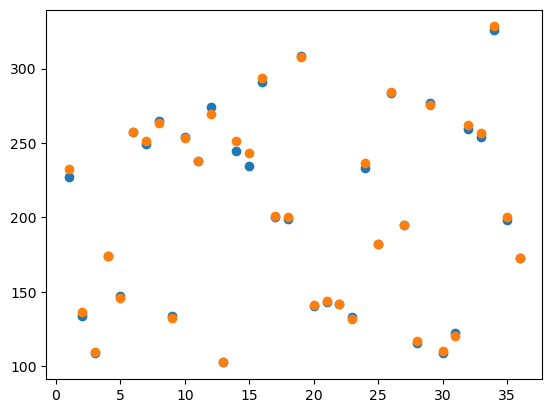

In [156]:
plt.plot(x_coord,((GPEnsemblePredict(models,likelihoods,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[0])).tolist(),'o')
plt.plot(x_coord,y_test.values[:,0],'o')

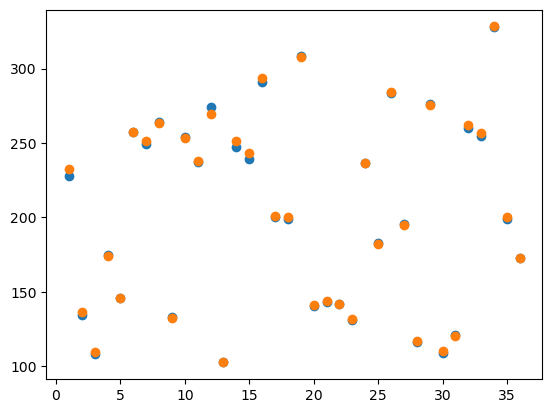

In [157]:
plt.plot(x_coord,((GPEnsemblePredict(modelsLR,likelihoodsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[0])).tolist(),'o')
plt.plot(x_coord,y_test.values[:,0],'o')

In [158]:
y

,"(A_TAT,)","(V_TAT,)"
0,127.156,227.8230
1,251.071,188.8540
2,163.448,164.8120
3,110.207,110.6940
4,140.815,136.1450
...,...,...
175,321.082,94.4139
176,141.936,190.0140
177,236.662,224.8330
178,248.667,167.9450


In [159]:
MSE.T

array([[6.77523867, 3.09694647, 6.5655962 ],
       [2.01242776, 0.92341371, 1.30493526]])

In [160]:
torch.split(torch.tensor(y_test.values.T),1,dim=0)

(tensor([[232.3740, 136.0810, 109.7010, 174.1980, 145.9460, 257.4710, 251.0710,
          263.6110, 132.4430, 253.4790, 238.0580, 269.6790, 102.4210, 251.1820,
          243.3990, 293.9230, 200.8450, 200.1320, 307.7590, 140.8150, 143.6020,
          141.6970, 131.8700, 236.3190, 181.9400, 284.2150, 194.9670, 116.6180,
          275.1840, 110.2070, 120.4670, 262.3260, 256.6380, 328.2840, 200.1360,
          172.4190]], dtype=torch.float64),
 tensor([[161.2020, 146.8570, 237.8320, 112.1920,  88.5843, 132.2110, 188.8540,
          122.0900, 148.1340, 124.4890, 107.3120, 173.8220, 123.1670, 174.2230,
          119.5790, 103.7740, 104.4230, 101.7830, 158.2120, 136.1450, 162.0710,
          104.2330, 185.6180, 113.4480, 127.5390, 128.2440,  93.0340, 189.7530,
          121.1850, 110.6940,  82.2549, 132.2110, 178.0800, 167.1690, 146.3500,
          106.4440]], dtype=torch.float64))

In [161]:
GPEnsemblePredict(modelsLR,likelihoodsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)

[tensor([228.0725, 134.5347, 108.1762, 174.5548, 145.6408, 257.6647, 249.3268,
         264.2424, 133.1635, 253.9243, 237.2465, 274.2481, 102.4297, 247.4258,
         239.2447, 290.9100, 200.3438, 198.7774, 308.5836, 140.4084, 142.7583,
         141.8135, 130.9326, 236.3590, 182.6250, 283.2758, 195.2262, 116.2642,
         276.3633, 108.8368, 121.1678, 260.2458, 254.3841, 328.1633, 198.5968,
         172.9118], grad_fn=<AddBackward0>),
 tensor([161.1105, 147.3033, 237.6671, 111.9583,  87.5186, 130.2831, 190.1161,
         121.9419, 148.7964, 123.4444, 108.2156, 174.7770, 122.0393, 174.6756,
         119.1631, 103.8213, 104.4577, 101.1165, 158.9537, 136.4330, 162.6060,
         104.0854, 183.1503, 113.9274, 127.3943, 127.4981,  93.0463, 189.4417,
         121.5516, 113.3622,  80.6270, 132.0537, 176.4818, 167.7823, 146.1184,
         106.9763], grad_fn=<AddBackward0>)]

In [162]:
LRGPEnsemblePredict(regression_model, modelsZM,likelihoodsZM,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)

[tensor([[226.8208, 134.4579, 108.8654, 173.9575, 146.0838, 257.7415, 249.8304,
          264.2484, 133.0002, 254.1894, 237.6765, 274.4265, 102.5071, 244.3748,
          235.2921, 290.3613, 199.9911, 199.0793, 307.3518, 140.4182, 142.5207,
          141.5482, 131.1738, 233.0501, 182.4045, 282.4176, 194.8222, 115.5600,
          276.6222, 108.5086, 121.3982, 259.2599, 253.4481, 326.3896, 198.3210,
          173.0942]], dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[160.3166, 147.4448, 237.4199, 112.3579,  87.3981, 129.8752, 187.2737,
          121.5061, 148.8175, 123.3226, 107.5177, 174.4551, 121.5513, 174.3898,
          119.7258, 103.8646, 104.4672, 102.2637, 156.2610, 135.8787, 162.8987,
          104.4298, 183.0562, 113.9255, 127.6618, 127.5584,  93.0303, 189.0387,
          121.1605, 112.7072,  80.6886, 131.7951, 174.7289, 166.8961, 145.9119,
          106.9073]], dtype=torch.float64, grad_fn=<AddBackward0>)]

In [417]:
inputNorm,inputMean,inputStd = normalise(X)

outputNorm,outMean,outStd=normalise(y)

In [418]:
models, likelihoods = GPEnsemble(inputNorm,outputNorm)

0
1


In [419]:
modelsLR, likelihoodsLR = GPEnsemble(inputNorm,outputNorm,meanFunc="linear")

0
1


In [420]:
regression_model, modelsZM, likelihoodsZM=LRGPEnsemble(inputNorm,outputNorm)

0
1


In [421]:
nMod=outputNorm.shape[1]
nInput = inputNorm.shape[1]

In [422]:
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_train.iloc[:,i]),np.max(X_train.iloc[:,i])])
    print(boundsMaxMin[i])

[0.380173, 0.798883]
[0.200114, 0.499215]
[1.2811, 8.39681]
[0.300285, 1.02928]
[0.201206, 0.499887]
[1.02207, 5.67575]


In [423]:
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(inputNorm.iloc[:,i]),np.max(inputNorm.iloc[:,i])])
    print(boundsMaxMin[i])

[-1.7299006611692156, 1.7225465552907784]
[-1.7290789003370721, 1.7217277414801047]
[-1.7253041777413964, 1.7297942760822342]
[-1.7307000363223575, 1.7289863698084669]
[-1.719926276162042, 1.7321604339951135]
[-1.7149833104147123, 1.7142073787228762]


In [424]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nInput,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 4096)

data1 = torch.tensor(param_values)
Ymean=GPEnsemblePredict(models,likelihoods,data1,outMean,outStd)
YmeanLR = GPEnsemblePredict(modelsLR,likelihoodsLR,data1,outMean,outStd)
# Run model (example)
#outMean = np.mean(modelOutputOrig,axis=0)
#outStd = np.std(modelOutputOrig,axis=0)
#nMod = modelOutputOrig.shape[1]
#Ymean=[]
#for j in range(nMod):
#    models[j].eval()
#    #Ymean.append(np.zeros([param_values.shape[0]]))
#    Ymean.append(outStd[j]*models[j](torch.tensor([np.hstack((param_values,np.zeros((param_values.shape[0],9))))])).mean+outMean[j])

    

C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_12632\491133695.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 4096)


In [425]:
data1.size()

torch.Size([57344, 6])

In [426]:
Si = []
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[i].detach().numpy(), print_to_console=True))

                        ST   ST_conf
(CV_ventricles,)  0.000075  0.000014
(k_ventricles,)   0.000030  0.000003
(k_FEC,)          0.000034  0.000004
(CV_atria,)       0.938864  0.036185
(k_atria,)        0.023414  0.001218
(k_BB,)           0.045284  0.002727
                        S1   S1_conf
(CV_ventricles,) -0.000011  0.000340
(k_ventricles,)   0.000088  0.000230
(k_FEC,)          0.000054  0.000236
(CV_atria,)       0.930607  0.044612
(k_atria,)        0.021079  0.006784
(k_BB,)           0.040028  0.008847
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.628073  0.028360
(k_ventricles,)   0.076157  0.003915
(k_FEC,)          0.312103  0.017078
(CV_atria,)       0.000075  0.000006
(k_atria,)        0.000105  0.000010
(k_BB,)           0.000080  0.000008
                        S1   S1_conf
(CV_ventricles,)  0.612403  0.035002
(k_ventricles,)   0.072224  0.012516
(k_FEC,)          0.298488  0.026896
(CV_atria,)       0.000002

In [427]:
SiLR = []
for i in range(nMod):
    SiLR.append(sobol.analyze(problem, YmeanLR[i].detach().numpy(), print_to_console=True))

                        ST       ST_conf
(CV_ventricles,)  0.000045  4.138406e-06
(k_ventricles,)   0.000010  6.964893e-07
(k_FEC,)          0.000011  8.939184e-07
(CV_atria,)       0.938477  3.175822e-02
(k_atria,)        0.023277  1.332086e-03
(k_BB,)           0.045768  2.536671e-03
                        S1   S1_conf
(CV_ventricles,)  0.000013  0.000278
(k_ventricles,)   0.000015  0.000127
(k_FEC,)          0.000007  0.000134
(CV_atria,)       0.930130  0.040867
(k_atria,)        0.021391  0.007120
(k_BB,)           0.040401  0.010642
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.627238  0.026080
(k_ventricles,)   0.076460  0.004233
(k_FEC,)          0.312495  0.013470
(CV_atria,)       0.000093  0.000009
(k_atria,)        0.000118  0.000013
(k_BB,)           0.000061  0.000007
                        S1   S1_conf
(CV_ventricles,)  0.611757  0.032679
(k_ventricles,)   0.072558  0.013133
(k_FEC,)          0.299079  0.02686

# Model 2: Linear regression + Zero Mean GP

In [428]:


# generate random data-set

# sckit-learn implementation

# Model initialization
#regression_model = LinearRegression()
# Fit the data(train the model)
#regression_model.fit(modeWeights, modelOutput)
# Predict
#y_predicted = regression_model.predict(modeWeights)

# model evaluation
#rmse = mean_squared_error(modelOutput, y_predicted)
#r2 = r2_score(modelOutput, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
#print('Intercept:', regression_model.intercept_)
#print('Root mean squared error: ', rmse)
#print('R2 score: ', r2)


In [429]:
#modelOutputAdjusted = modelOutput - y_predicted

In [430]:
#modelsZM, likelihoodsZM = GPEnsemble(modeWeights,modelOutputAdjusted,zeroMean=True)

In [431]:
YmeanSens = LRGPEnsemblePredict(regression_model,modelsZM,likelihoodsZM,data1,outMean,outStd)

In [432]:
SiZM = []
for i in range(nMod):
    SiZM.append(sobol.analyze(problem, YmeanSens[i].detach().numpy().squeeze(), print_to_console=True))

                        ST   ST_conf
(CV_ventricles,)  0.000051  0.000007
(k_ventricles,)   0.000016  0.000001
(k_FEC,)          0.000016  0.000001
(CV_atria,)       0.939189  0.032891
(k_atria,)        0.023155  0.001268
(k_BB,)           0.045204  0.002843
                        S1   S1_conf
(CV_ventricles,)  0.000009  0.000317
(k_ventricles,)   0.000045  0.000192
(k_FEC,)          0.000025  0.000185
(CV_atria,)       0.930988  0.038549
(k_atria,)        0.020994  0.006453
(k_BB,)           0.039896  0.011688
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.627434  0.026596
(k_ventricles,)   0.076617  0.004371
(k_FEC,)          0.312188  0.014778
(CV_atria,)       0.000060  0.000006
(k_atria,)        0.000101  0.000010
(k_BB,)           0.000050  0.000005
                        S1   S1_conf
(CV_ventricles,)  0.611835  0.030275
(k_ventricles,)   0.072694  0.012511
(k_FEC,)          0.298665  0.027450
(CV_atria,)      -0.000012

In [433]:
SiZM_first=np.zeros((nInput,nMod))
SiZM_total=np.zeros((nInput,nMod))
Si_first=np.zeros((nInput,nMod))
Si_total=np.zeros((nInput,nMod))
SiLR_first=np.zeros((nInput,nMod))
SiLR_total=np.zeros((nInput,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = SiZM[i].to_df()
    SiZM_first[:,i] =  first_Si.iloc[:,0]
    SiZM_total[:,i] =  total_Si.iloc[:,0]
    
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]
    
    total_Si, first_Si, second_Si = SiLR[i].to_df()
    SiLR_first[:,i] =  first_Si.iloc[:,0]
    SiLR_total[:,i] =  total_Si.iloc[:,0]

## Linear Regression + GP

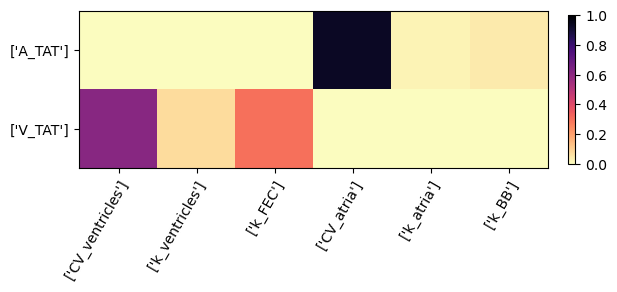

In [434]:
inputs = x_labels.values.tolist()
outputs = y_labels.values.tolist()
fig, ax = plt.subplots()
im = ax.imshow(SiZM_first.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)), labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [435]:
SiZM_first[:,0]

array([8.67366537e-06, 4.52151198e-05, 2.46551138e-05, 9.30988411e-01,
       2.09936596e-02, 3.98963884e-02])

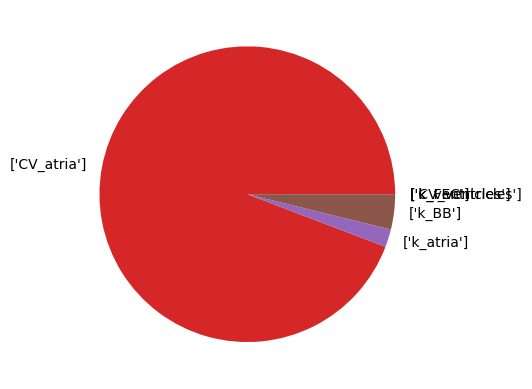

In [178]:
fig, ax = plt.subplots()
ax.pie(SiZM_first[:,0]/np.max(SiZM_first[:,0]), labels=inputs);


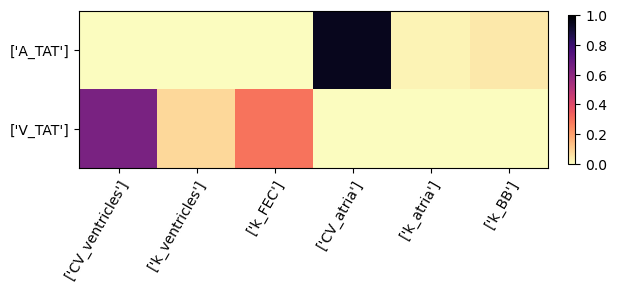

In [179]:
fig, ax = plt.subplots()
im = ax.imshow(SiZM_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)), labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.colorbar(im,fraction=0.015, pad=0.04)

## Basic GP

In [180]:
np.max(SiZM_total)

0.9416977140591901

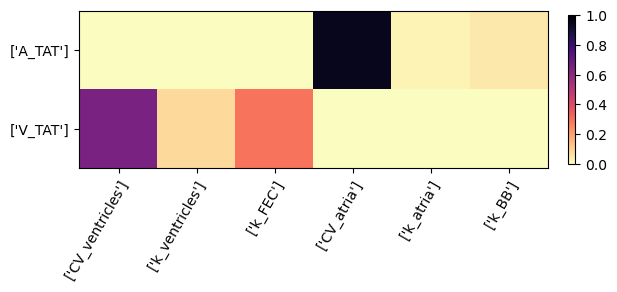

In [181]:
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)), labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [436]:
Si_first[:,0]

array([-1.07773428e-05,  8.75360603e-05,  5.38142588e-05,  9.30606615e-01,
        2.10794013e-02,  4.00277766e-02])

ValueError: Wedge sizes 'x' must be non negative values

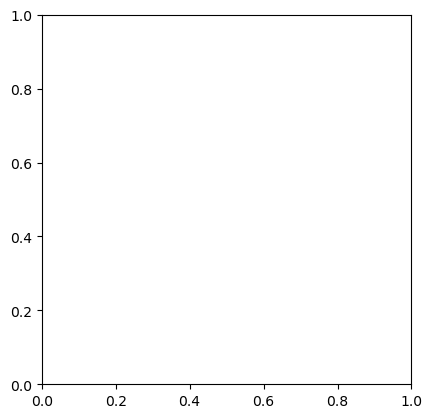

In [437]:
fig, ax = plt.subplots()
ax.pie(Si_first[:,0]/np.max(Si_first[:,0]), labels=inputs);


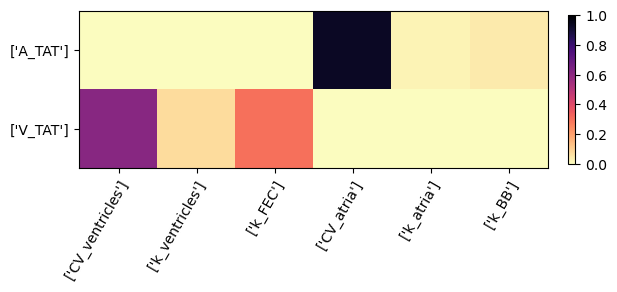

In [438]:
fig, ax = plt.subplots()
im = ax.imshow(Si_first.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)), labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# Linear Mean GP

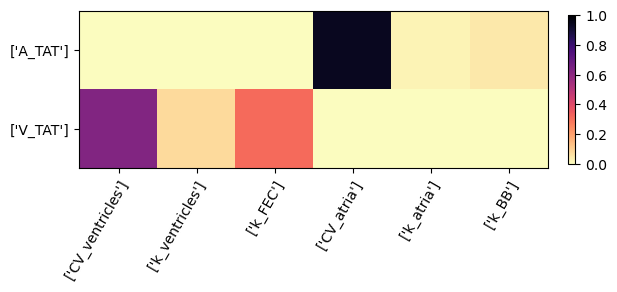

In [439]:
fig, ax = plt.subplots()
im = ax.imshow(SiLR_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)), labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [440]:
modelsZM[1].likelihood.noise.item()

0.00011476309737190604

# Leave one out MSE

In [192]:
import random

In [193]:
def standardise(data,mean,std):
    dataStandard = (data-mean)/std.T
    return dataStandard

In [194]:
def EnsembleMSE(models,likelihoods,modelInput,modelOutput):
    MSE = np.zeros(modelOutput.shape[1])
    nMod=len(models)
    for i in range(nMod):
        models[i].eval()
        likelihoods[i].eval()
        MSE[i] = (((outputTrainStd[i]*likelihoods[i](models[i](torch.tensor(modelInput.values).float())).mean-outputTrainStd[i]*torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [195]:
def LREnsembleMSE(GPmodels,likelihoods,LRModel,modelInput,modelOutput):
    MSE = np.zeros(modelOutput.shape[1])
    nMod = len(models)
    y_predicted = regression_model.predict(modelInput)
    for i in range(nMod):
        GPmodels[i].eval()
        likelihoods[i].eval()
        MSE[i] = (((outputTrainStd[i]*(torch.tensor(y_predicted[:,i])+likelihoods[i](GPmodels[i](torch.tensor(modelInput.values).float())).mean)-outputTrainStd[i]*torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [196]:
random.sample(range(0,50),10)

[13, 25, 41, 1, 29, 31, 45, 24, 44, 36]

In [197]:
GP_MSE = np.zeros(outputNorm.shape[1])
LRGP_MSE = np.zeros(outputNorm.shape[1])
LMGP_MSE = np.zeros(outputNorm.shape[1])
iters = inputNorm.shape[0]
nMod = outputNorm.shape[1]

for i in range(iters):

    models2=[]
    likelihoods2=[]
    
    modelsLR2 = []
    likelihoodsLR2=[]
    
    modelsZM2=[]
    likelihoodsZM2=[]
    

    testIndices = [i]
    inputTest = inputOrig.iloc[testIndices,:]
    inputTrain = inputOrig[~inputOrig.index.isin([inputOrig.index[i]])]
    outputTest = outputOrig.iloc[testIndices,:]
    outputTrain = outputOrig.iloc[~outputOrig.index.isin([outputOrig.index[i]])]
    
    inputTrainNorm,inputTrainMean,inputTrainStd = normalise(inputTrain)
    inputTestNorm=(inputTest-inputTrainMean)/inputTrainStd
    
    outputTrainNorm,outputTrainMean,outputTrainStd = normalise(outputTrain)
    outputTestNorm=(outputTest-outputTrainMean)/outputTrainStd
    
    y_predicted = regression_model.predict(inputTrainNorm)

    for j in range(nMod):

        likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
        model2 = ExactGPModel(torch.tensor(inputTrainNorm.values), torch.tensor(outputTrainNorm.iloc[:,j].values).squeeze(), likelihood2)


        model2.likelihood.noise_covar.noise= models[j].likelihood.noise_covar.noise,
        model2.covar_module.base_kernel.lengthscale= models[j].covar_module.base_kernel.lengthscale.tolist(),
        model2.covar_module.outputscale=models[j].covar_module.outputscale,
        model2.mean_module.constant=models[j].mean_module.constant.tolist()
        model2.train()
        models2.append(model2)
        likelihoods2.append(likelihood2)
        
        likelihoodLR2 = gpytorch.likelihoods.GaussianLikelihood()
        modelLR2 = ExactLRGPModel(torch.tensor(inputTrainNorm.values).float(), torch.tensor(outputTrainNorm.iloc[:,j].values).squeeze().float(), likelihoodLR2)


        modelLR2.likelihood.noise_covar.noise= modelsLR[j].likelihood.noise_covar.noise,
        modelLR2.covar_module.base_kernel.lengthscale= modelsLR[j].covar_module.base_kernel.lengthscale.tolist(),
        modelLR2.covar_module.outputscale=modelsLR[j].covar_module.outputscale,
        modelLR2.mean_module.weights=modelsLR[j].mean_module.weights
        modelLR2.mean_module.bias=modelsLR[j].mean_module.bias
        modelLR2.train()
        modelsLR2.append(modelLR2)
        likelihoodsLR2.append(likelihoodLR2)
    
        modelOutputAdjusted = outputTrainNorm - y_predicted
        
        likelihoodZM2 = gpytorch.likelihoods.GaussianLikelihood()
        modelZM2 = ZeroMeanGPModel(torch.tensor(inputTrainNorm.values), torch.tensor(modelOutputAdjusted.iloc[:,j].values).squeeze(), likelihood2)

        modelZM2.likelihood.noise_covar.noise= modelsZM[j].likelihood.noise_covar.noise,
        modelZM2.covar_module.base_kernel.lengthscale= modelsZM[j].covar_module.base_kernel.lengthscale.tolist(),
        modelZM2.covar_module.outputscale=modelsZM[j].covar_module.outputscale,
        #modelZM2.mean_module.constant=modelsZM[j].mean_module.constant.tolist()
        modelZM2.train()
        modelsZM2.append(modelZM2)
        likelihoodsZM2.append(likelihoodZM2)
        
    GP_MSE+= EnsembleMSE(models2,likelihoods2,inputTestNorm,outputTestNorm)/iters
    LRGP_MSE+=LREnsembleMSE(modelsZM2,likelihoodsZM2,regression_model,inputTestNorm,outputTestNorm)/iters
    LMGP_MSE+=EnsembleMSE(modelsLR2,likelihoodsLR2,inputTestNorm,outputTestNorm)/iters

In [198]:
dataset = pd.DataFrame({'GP MSE': GP_MSE, 'LRGP MSE': LRGP_MSE,'LMGP MSE': LMGP_MSE}, columns=['GP MSE', 'LRGP MSE', 'LMGP MSE'])
dataset.index = list(outputOrig.columns)

In [199]:
dataset

,GP MSE,LRGP MSE,LMGP MSE
"(A_TAT,)",2.374417,1.915979,1.798480
"(V_TAT,)",1.128991,0.927477,0.964744


In [200]:
modelsZM[0].likelihood.noise.item()

0.00010734867100836709

In [201]:
LRGP_MSE.tolist()

[1.9159789038315664, 0.9274773153304463]

In [202]:
GP_MSE = np.zeros(outputNorm.shape[1])
LRGP_MSE = np.zeros(outputNorm.shape[1])

for i in range(iters):

    testIndices = [i]
    inputTest = inputOrig.iloc[testIndices,:]
    inputTrain = inputOrig[~inputOrig.index.isin([inputOrig.index[i]])]
    outputTest = outputOrig.iloc[testIndices,:]
    outputTrain = outputOrig.iloc[~outputOrig.index.isin([outputOrig.index[i]])]
    
    inputTrainNorm,inputTrainMean,inputTrainStd = normalise(inputTrain)
    inputTestNorm=(inputTest-inputTrainMean)/inputTrainStd
    
    outputTrainNorm,outputTrainMean,outputTrainStd = normalise(outputTrain)
    outputTestNorm=(outputTest-outputTrainMean)/outputTrainStd
    
    models, likelihoods= GPEnsemble(inputTrainNorm,outputTrainNorm)
    
    GP_MSE+= EnsembleMSE(models,likelihoods,inputTestNorm,outputTestNorm)/iters
    
    regression_model, modelsZM, likelihoodsZM = LRGPEnsemble(inputTrainNorm,outputTrainNorm)
    
    
    LRGP_MSE+=LREnsembleMSE(modelsZM,likelihoodsZM,regression_model,inputTestNorm,outputTestNorm)/iters

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [203]:
GP_MSE

array([2.69355001, 1.11770362])

In [ ]:
dataset = pd.DataFrame({'GP MSE': GP_MSE, 'LRGP MSE': LRGP_MSE}, columns=['GP MSE', 'LRGP MSE'])
dataset.index = list(outputOrig.columns)

In [ ]:
dataset

In [269]:
inputNorm.iloc[:,[0,3]]

,"(CV_ventricles,)","(CV_atria,)"
67,0.306260,-0.969200
141,-1.441605,1.339890
88,0.969388,0.344957
30,0.919335,-1.329597
57,-1.054113,-0.315881
...,...,...
83,-0.657008,0.267552
136,-0.742451,-0.838235
133,1.503548,-0.640924
105,0.209907,0.547353


In [441]:
inputNorm,inputMean,inputStd = normalise(X_train)

In [442]:
outputNorm,outMean,outStd=normalise(y_train)

0
1
0
1
0
1
0
1
0
1
0
1


In [445]:
MSE = np.zeros((7,2))
for i in range(2):
    MSE[0,i] =((GPEnsemblePredict(models_1A,likelihoods_1A,torch.tensor(((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[1,i] =((GPEnsemblePredict(models_2A,likelihoods_2A,torch.tensor(((X_test.iloc[:,[3,5]]-inputMean[[3,5]])/inputStd[[3,5]]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[2,i] =((GPEnsemblePredict(models_3A,likelihoods_3A,torch.tensor(((X_test.iloc[:,3:6]-inputMean[3:6])/inputStd[3:6]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[3,i] =((GPEnsemblePredict(models_1V,likelihoods_1V,torch.tensor(((X_test.iloc[:,0:1]-inputMean[0:1])/inputStd[0:1]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[4,i] =((GPEnsemblePredict(models_2V,likelihoods_2V,torch.tensor(((X_test.iloc[:,[0,2]]-inputMean[[0,2]])/inputStd[[0,2]]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[5,i] =((GPEnsemblePredict(models_3V,likelihoods_3V,torch.tensor(((X_test.iloc[:,0:3]-inputMean[0:3])/inputStd[0:3]).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[6,i] =((GPEnsemblePredict(modelsLR,likelihoodsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()

In [451]:
MSE.T

array([[5.49098221e+02, 2.07078667e+02, 1.85679127e+00, 4.44245875e+03,
        4.35259870e+03, 5.94503814e+03, 2.43054703e+01],
       [1.20117355e+03, 1.21210662e+03, 1.29933315e+03, 6.76657320e+02,
        1.31821443e+02, 8.06877385e-01, 4.70857404e+00]])

In [453]:
(1-MSE/np.var(y_train).values)

array([[ 0.88527444,  0.21801975],
       [ 0.95673412,  0.21090218],
       [ 0.99961205,  0.15411653],
       [ 0.07181708,  0.55948692],
       [ 0.09059195,  0.91418246],
       [-0.2421236 ,  0.99947471],
       [ 0.99492175,  0.99693465]])

In [237]:
inputNorm.iloc[:,3:4]

,"(CV_atria,)"
67,-0.969200
141,1.339890
88,0.344957
30,-1.329597
57,-0.315881
...,...
83,0.267552
136,-0.838235
133,-0.640924
105,0.547353


In [239]:
np.var(y_test)

(A_TAT,)    4141.266429
(V_TAT,)    1168.657262
dtype: float64

In [244]:
1-(4/4141)

0.9990340497464381

In [107]:
np.sort(y_test.values[:,0])

array([102.421, 109.701, 110.207, 116.618, 120.467, 131.87 , 132.443,
       136.081, 140.815, 141.697, 143.602, 145.946, 172.419, 174.198,
       181.94 , 194.967, 200.132, 200.136, 200.845, 232.374, 236.319,
       238.058, 243.399, 251.071, 251.182, 253.479, 256.638, 257.471,
       262.326, 263.611, 269.679, 275.184, 284.215, 293.923, 307.759,
       328.284])

In [134]:
X_GPE=GPEnsemblePredict(models_2A,likelihoods_2A,torch.tensor(((X_test.iloc[:,[3,5]]-inputMean[[3,5]])/inputStd[[3,5]]).values),outMean,outStd)[0].tolist()
X_LR=LREnsemblePredict(LR_1A,torch.tensor(((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4]).values),outMean,outStd)[0]


In [135]:
X_LR

tensor([[224.6351, 115.7152,  82.4350, 199.9277, 184.1672, 269.9497, 259.8669,
         276.8797, 131.4656, 253.3968, 265.7564, 269.0422,  99.9672, 234.3907,
         217.2764, 285.7320, 212.6948, 207.6677, 279.8419, 114.4763, 139.9068,
         166.6898,  81.0990, 210.9708, 191.1355, 288.2174, 211.9772, 128.7912,
         263.4555,  84.7661, 125.7669, 229.8996, 247.0249, 299.1100, 232.5523,
         175.5592]], dtype=torch.float64)

Text(0, 0.5, 'V_TAT')

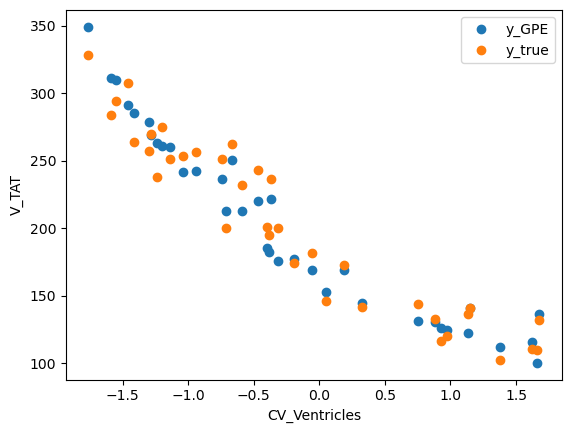

In [136]:
plt.plot((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4],X_GPE,'o')
plt.plot((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4],y_test.values[:,0],'o')
plt.legend(('y_GPE','y_true'))
plt.xlabel('CV_Ventricles')
plt.ylabel('V_TAT')


Text(0, 0.5, 'V_TAT')

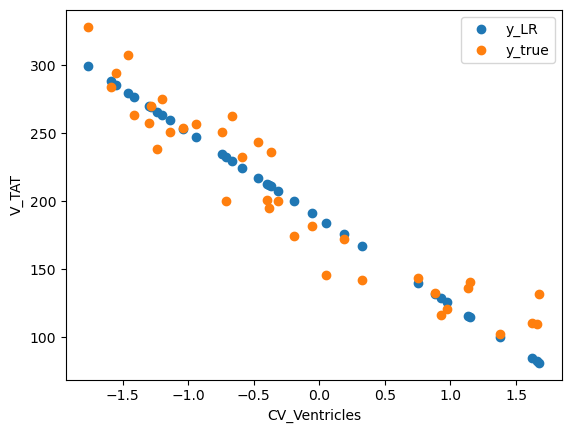

In [137]:

plt.plot((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4],X_LR.T,'o')
plt.plot((X_test.iloc[:,3:4]-inputMean[3:4])/inputStd[3:4],y_test.values[:,0],'o')
plt.legend(('y_LR','y_true'))
plt.xlabel('CV_Ventricles')
plt.ylabel('V_TAT')